<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Подготовка данных

Произведем импорт неободимых библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import pandas_profiling
from imblearn.over_sampling import SMOTE

import numpy as np
import random
import warnings

c:\dev\learning_with_a_teacher\venv\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.


Настроим отображение предупреждений в коде, а именно отключим некретические, которые не влияют на ход выполнения проекта.

In [2]:
warnings.filterwarnings('ignore')

Ограгичим количество знаков при выводе данных

In [3]:
pd.set_option('display.float_format', '{:,.6f}'.format)

Уберем оганичения на вывод столбцов при выводе таблицы, что упрастит работу с данными, при их просмотре.

In [4]:
pd.set_option('display.max_columns', None)

Cохраним данные таблицы в переменную Data

In [5]:
data = pd.read_csv('Churn.csv')

Выведем первые 5-ть строк таблицы

In [6]:
data.head(5)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

    Tenure        Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0 2.000000       0.000000              1          1               1   
1 1.000000  83,807.860000              1          0               1   
2 8.000000 159,660.800000              3          1               0   
3 1.000000       0.000000              2          0               0   
4 2.000000 125,510.820000              1          1               1   

   EstimatedSalary  Exited  
0   101,348.880000       1  
1   112,542.580000       0  
2   113,931.570000       1  
3    93,826.630000       0  
4    79,084.100000       0

Выведем общую информацию о таблице

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Изучив данные, мы можем удалить следующие столбцы, которы явно не влияют на факт ухода клиента, чтобы избежать переизбытка данных и не обрабатывать их, а именно: CustomerId- уникальный индификатор клиента, Surname - фамилия клиента, RowNumber - индекс строки в данных.

Удалим вышеуказанные данные.

In [8]:
data.drop(columns=['CustomerId','Surname', 'RowNumber'],axis=1,inplace=True)

Посмотрим в каких столбцах пропущены данные.

In [115]:
pd.DataFrame(round(data.isna().mean()*100,))

0
CreditScore     0.000000
Geography       0.000000
Gender          0.000000
Age             0.000000
Tenure          0.000000
Balance         0.000000
NumOfProducts   0.000000
HasCrCard       0.000000
IsActiveMember  0.000000
EstimatedSalary 0.000000
Exited          0.000000

Мы можем заметить, что 9 процентов данных пропущено в столбце 'Tenure'- количество лет, которых человек является клиентом банка. Заполним их случайными значениями, что бы не влиять на распределение. Для этого используем метод 'bfill', который запишет в отсутствующее графу, предыдущее значения. Мы моги бы заполнить пропуски медианным значением, но это привело бы к аномальному всплеску одного признака. А нам это не нужно. 

In [10]:
data['Tenure'] = data['Tenure'].fillna(method='bfill')

Проверим заполнились ли пропуски.

In [11]:
data['Tenure'].isna().sum()

1

Заполним одно оставшиеся значение медианой.

In [12]:
data.loc[data['Tenure'].isna(), 'Tenure'] = data['Tenure'].median()

In [13]:
data['Tenure'].isna().sum()

0

In [14]:
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

Пропусков в данных нет.

Выведем таблицу после преобразваония

Чтобы избежать мультиколлинеарность, посмотрим наколько сильно зависимы друг от друга числовые значения. Создадим список числовых значений, исключив столбцы с категориальными значениями. 

In [15]:
numeric = ['CreditScore','Age','Balance','NumOfProducts','EstimatedSalary','Tenure']

Расчитаем значение кореляции для стобцов, указанных выше.

In [16]:
data.loc[:, numeric].corr()

CreditScore       Age   Balance  NumOfProducts  \
CreditScore         1.000000 -0.003965  0.006268       0.012238   
Age                -0.003965  1.000000  0.028308      -0.030680   
Balance             0.006268  0.028308  1.000000      -0.304180   
NumOfProducts       0.012238 -0.030680 -0.304180       1.000000   
EstimatedSalary    -0.001384 -0.007201  0.012797       0.014204   
Tenure              0.001586 -0.011724 -0.011477       0.012096   

                 EstimatedSalary    Tenure  
CreditScore            -0.001384  0.001586  
Age                    -0.007201 -0.011724  
Balance                 0.012797 -0.011477  
NumOfProducts           0.014204  0.012096  
EstimatedSalary         1.000000  0.003184  
Tenure                  0.003184  1.000000

Сильной корреляционной зависимости н еобнаружено, максимальное значение 0.3, дополнтельного удаления данных не потребуется. Построим графики для столбцов с числовыми значениями.

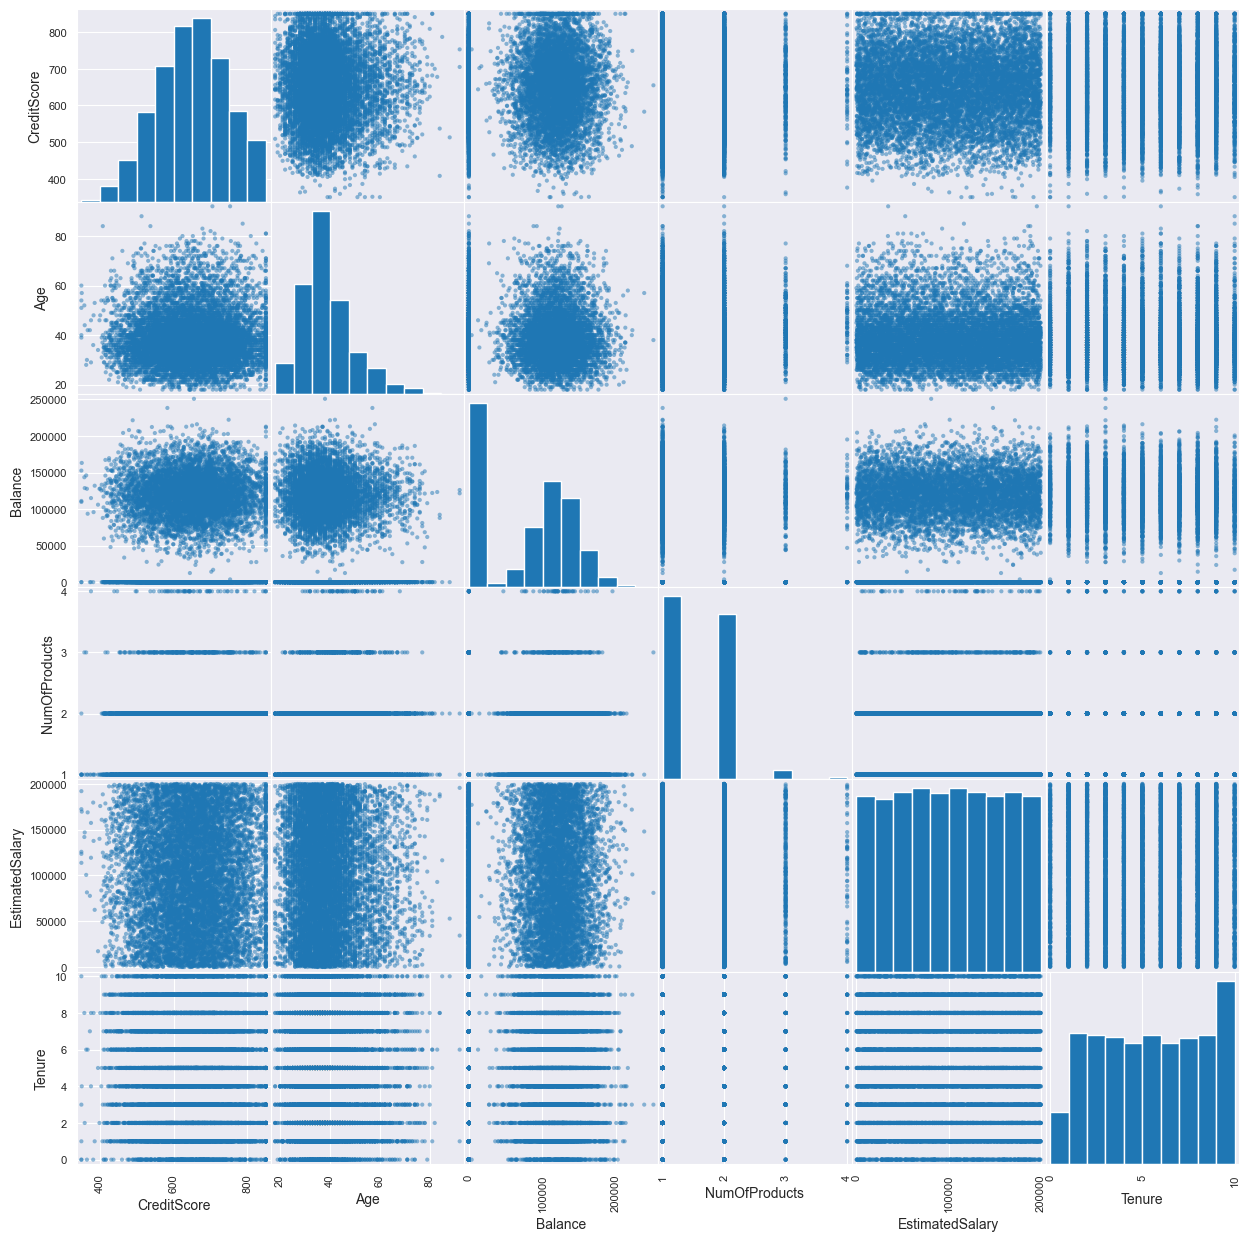

In [17]:
pd.plotting.scatter_matrix(data.loc[:,numeric],figsize=(15,15));

Ложная кареляция также отсутствует. Для наилучшей демонстрации данных и их узечения применим pandas_profiling. Установим его и выведем отчет о датафрейме.

In [19]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

На этапе подготовки данных, мы выявили столбцы, которые не влияют на обучение модели, а именно: CustomerId, Surname, RowNumber. Было принято решение удалить их. Та кже мы заполнили пустые значения в столбце Tenure, применив метод, позволяющий заполнить значения 'рандомно'. Мы изучили зависимости между числовыми значениями и выявили, что сильной кореляционной зависимотси нет, максимальное значение кореляции - 0.3. Ложной рореляционной зависимоти мы так же не обнаружили. Для удобного изучения данных мы создали отчет. Приступим к исследовательским задачам. 

## Исследование задачи

Выделим признаки и целевой признак. 

In [20]:
target = data['Exited']
features = data.drop('Exited', axis=1)

Разделим датасет на 3 выборки, которые позволнять нам обучить модель, провести тесты  и проверить модели на валидационных данных.

In [21]:
features_valid_train, features_test_nc, target_valid_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345, stratify=target
)

In [22]:
features_train_nc, features_valid_nc, target_train, target_valid = train_test_split(
    features_valid_train, target_valid_train, test_size=0.25, 
    random_state=12345, stratify=target_valid_train)

In [23]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['Geography', 'Gender']),
    remainder='passthrough')
transformed = transformer.fit_transform(features_test_nc)
features_test = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
display(features_test.head())

onehotencoder__Geography_France  onehotencoder__Geography_Germany  \
0                         0.000000                          0.000000   
1                         1.000000                          0.000000   
2                         1.000000                          0.000000   
3                         0.000000                          0.000000   
4                         1.000000                          0.000000   

   onehotencoder__Geography_Spain  onehotencoder__Gender_Female  \
0                        1.000000                      0.000000   
1                        0.000000                      0.000000   
2                        0.000000                      0.000000   
3                        1.000000                      1.000000   
4                        0.000000                      1.000000   

   onehotencoder__Gender_Male  remainder__CreditScore  remainder__Age  \
0                    1.000000              850.000000       48.000000   
1                    1.000000              651.000000       28.000000   
2                    1.000000              714.000000       34.000000   
3                    0.000000              782.000000       41.000000   
4                    0.000000              521.000000       41.000000   

   remainder__Tenure  remainder__Balance  remainder__NumOfProducts  \
0           2.000000            0.000000                  1.000000   
1          10.000000       79,562.980000                  1.000000   
2          10.000000            0.000000                  2.000000   
3           4.000000            0.000000                  1.000000   
4           2.000000            0.000000                  2.000000   

   remainder__HasCrCard  remainder__IsActiveMember  remainder__EstimatedSalary  
0              1.000000                   0.000000              169,425.300000  
1              1.000000                   1.000000               74,687.370000  
2              1.000000                   1.000000               80,234.140000  
3              1.000000                   0.000000              132,943.880000  
4              1.000000                   1.000000              113,089.430000

In [24]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['Geography', 'Gender']),
    remainder='passthrough')
transformed = transformer.fit_transform(features_train_nc)
features_train = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
display(features_train.head())

onehotencoder__Geography_France  onehotencoder__Geography_Germany  \
0                         0.000000                          0.000000   
1                         1.000000                          0.000000   
2                         1.000000                          0.000000   
3                         1.000000                          0.000000   
4                         0.000000                          0.000000   

   onehotencoder__Geography_Spain  onehotencoder__Gender_Female  \
0                        1.000000                      0.000000   
1                        0.000000                      1.000000   
2                        0.000000                      1.000000   
3                        0.000000                      1.000000   
4                        1.000000                      0.000000   

   onehotencoder__Gender_Male  remainder__CreditScore  remainder__Age  \
0                    1.000000              636.000000       45.000000   
1                    0.000000              808.000000       33.000000   
2                    0.000000              758.000000       34.000000   
3                    0.000000              809.000000       39.000000   
4                    1.000000              603.000000       24.000000   

   remainder__Tenure  remainder__Balance  remainder__NumOfProducts  \
0          10.000000            0.000000                  2.000000   
1           2.000000      103,516.870000                  1.000000   
2           1.000000      154,139.450000                  1.000000   
3           5.000000            0.000000                  1.000000   
4           1.000000      165,149.130000                  2.000000   

   remainder__HasCrCard  remainder__IsActiveMember  remainder__EstimatedSalary  
0              1.000000                   1.000000              159,463.800000  
1              1.000000                   0.000000              113,907.800000  
2              1.000000                   1.000000               60,728.890000  
3              1.000000                   0.000000               77,705.750000  
4              1.000000                   0.000000               21,858.280000

In [25]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['Geography', 'Gender']),
    remainder='passthrough')
transformed = transformer.fit_transform(features_valid_nc)
features_valid = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
display(features_valid.head())

onehotencoder__Geography_France  onehotencoder__Geography_Germany  \
0                         0.000000                          1.000000   
1                         0.000000                          1.000000   
2                         1.000000                          0.000000   
3                         1.000000                          0.000000   
4                         0.000000                          0.000000   

   onehotencoder__Geography_Spain  onehotencoder__Gender_Female  \
0                        0.000000                      0.000000   
1                        0.000000                      1.000000   
2                        0.000000                      0.000000   
3                        0.000000                      0.000000   
4                        1.000000                      0.000000   

   onehotencoder__Gender_Male  remainder__CreditScore  remainder__Age  \
0                    1.000000              659.000000       48.000000   
1                    0.000000              550.000000       42.000000   
2                    1.000000              850.000000       41.000000   
3                    1.000000              755.000000       36.000000   
4                    1.000000              703.000000       58.000000   

   remainder__Tenure  remainder__Balance  remainder__NumOfProducts  \
0           4.000000      123,593.220000                  2.000000   
1          10.000000      128,707.310000                  1.000000   
2           3.000000            0.000000                  2.000000   
3           8.000000            0.000000                  2.000000   
4           4.000000       92,930.920000                  1.000000   

   remainder__HasCrCard  remainder__IsActiveMember  remainder__EstimatedSalary  
0              1.000000                   0.000000               82,469.060000  
1              1.000000                   0.000000               63,092.650000  
2              1.000000                   0.000000              128,892.360000  
3              1.000000                   0.000000              176,809.870000  
4              0.000000                   1.000000               85,148.780000

Нормируем числовые данные

In [26]:
numeric = ['remainder__CreditScore','remainder__Age','remainder__Balance','remainder__NumOfProducts','remainder__EstimatedSalary','remainder__Tenure']

In [27]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

Выведем количество данных и проверим их соответствие. 

In [28]:
print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)

(6000, 13)
(2000, 13)
(2000, 13)


Проверим, сбалансированны ли данные. 

In [29]:
features[target == 0].shape[0]/features[target == 1].shape[0]

3.9091801669121256

Мы можем наблюдать дисбаланс классов, поскольку отрицательных ответов в 3.9 раза больше чем положительных. Продолжим работу на несбалансированных данных. 

Обучим базовую модель логистической регресси и расчитаем метрики на валидной выборке

In [30]:
model_log_reg = LogisticRegression(random_state=12345, solver='liblinear')
model_log_reg.fit(features_train, target_train)
predicted_test = model_log_reg.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.29906542056074764
ROC_auc: 0.5832141849091003


Построим Roc кривую, для наглядного отображения.

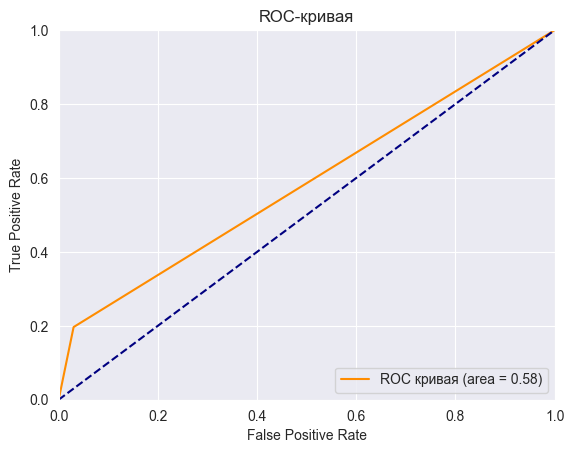

In [31]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
# строим график
plt.interactive(False)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

По данному графику и расчету значения Roc видно, что наша модель близка к случайной модели, поскольку значение Roc = 0.58, что слишком мало для показания качественнйо модели. Продолжим поиск лучшей модели и подберем оптимальные параметры для случайного леса. 

In [32]:
%%time
parameters = {
    'n_estimators' : [25,50,100,150],
    'criterion' : ['gini', 'entropy'],
    'max_depth':[5,10,20]
}

rfc = RandomForestClassifier(random_state=12345)

clf_rfc = GridSearchCV(
    estimator = rfc,
    param_grid = parameters,
    scoring = 'f1',
    cv=5)

clf_rfc.fit(features_train, target_train)

Wall time: 37.1 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='f1')

In [33]:
clf_rfc.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 25}

In [34]:
%%time
parameters = {
    'n_estimators' : [25,50,100,150],
    'criterion' : ['gini', 'entropy'],
    'max_depth':[5,10,20]
}

rfc = RandomForestClassifier(random_state=12345)

clf_rfc_random = RandomizedSearchCV(
    estimator = rfc,
    param_distributions = parameters,
    n_iter = 10,
    scoring = 'f1',
    cv=5)

clf_rfc_random.fit(features_train, target_train)

Wall time: 10 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20],
                                        'n_estimators': [25, 50, 100, 150]},
                   scoring='f1')

In [35]:
clf_rfc_random.best_params_

{'n_estimators': 25, 'max_depth': 10, 'criterion': 'gini'}

Обучим нашу модель на наилучших параметрах.

In [36]:
model_base_rfc = clf_rfc.best_estimator_.fit(features_train, target_train)
predicted_test = model_base_rfc.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5705614567526555
ROC_auc: 0.7108703464635668


In [37]:
model_base_rfc = clf_rfc_random.best_estimator_.fit(features_train, target_train)
predicted_test = model_base_rfc.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5439739413680782
ROC_auc: 0.69260477735054


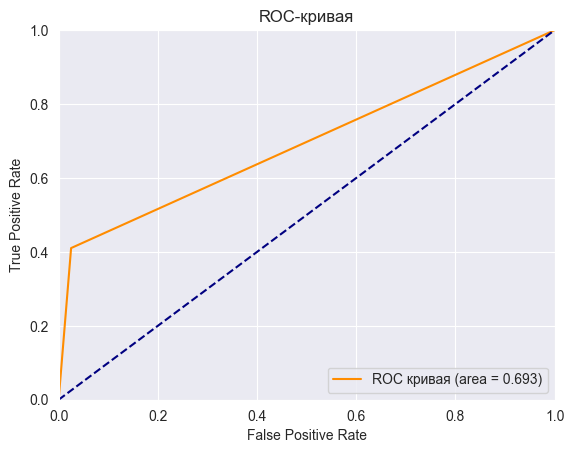

In [38]:
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Исходя из расчетов и графика. мы можем сделать вывод, что данная модель работает лучше, чем логистическая регрессия, значение Roc = 0.711, значит наша модель будет выдавать прогноз, отличный от случайной модели. Что должно положительно сказаться на работе аналитической системы.  Расчитаем метрики для градиентного бустинга и посмотрим на результативность работы данной модели. 

In [39]:
%%time
parameters = {
    'learning_rate' : [0.1, 0.01],
    'n_estimators' : [50, 100, 150],
    'max_depth':[3,5,10,20],
}

model_boost = GradientBoostingClassifier(random_state=12345)

clf_gbc = GridSearchCV(
    estimator = model_boost,
    param_grid = parameters,
    scoring = 'f1',
    cv=5)
    
clf_gbc.fit(features_train, target_train)

Wall time: 3min 20s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=12345),
             param_grid={'learning_rate': [0.1, 0.01],
                         'max_depth': [3, 5, 10, 20],
                         'n_estimators': [50, 100, 150]},
             scoring='f1')

In [44]:
clf_gbc.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

In [45]:
%%time
parameters = {
    'learning_rate' : [0.1, 0.01],
    'n_estimators' : [50, 100, 150],
    'max_depth':[3,5,10,20],
}

model_boost = GradientBoostingClassifier(random_state=12345)

clf_gbc_random = RandomizedSearchCV(
    estimator = model_boost,
    param_distributions = parameters,
    scoring = 'f1',
    n_iter = 10,
    cv=5)
    
clf_gbc_random.fit(features_train, target_train)

Wall time: 1min 33s


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(random_state=12345),
                   param_distributions={'learning_rate': [0.1, 0.01],
                                        'max_depth': [3, 5, 10, 20],
                                        'n_estimators': [50, 100, 150]},
                   scoring='f1')

In [46]:
clf_gbc_random.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

Обучим модель на подобранных, лучших гиперпараметрах. 

In [47]:
model_base_gbc = clf_gbc_random.best_estimator_.fit(features_train, target_train)
predicted_test = model_base_gbc.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5802469135802469
ROC_auc: 0.7143229516110873


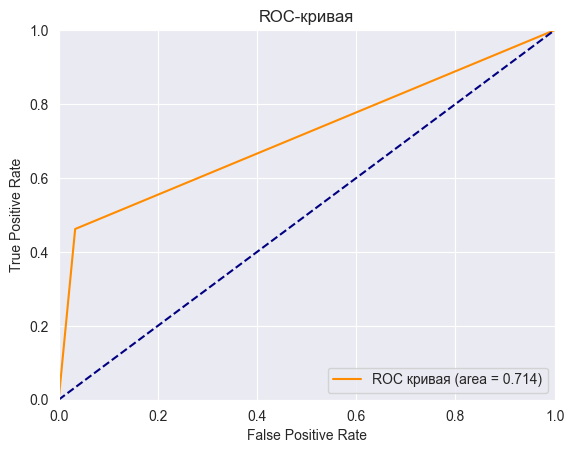

In [48]:
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Данная модель показала наилучший результать, хоть он и немного отличается от случайного дерева, но больше всегда лучше чем меньше. Посмотрим, как изменение порогового значения влияет на метрику модели.

In [49]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_test = probabilities_one_test > threshold 
    precision = precision_score(target_test,predicted_test) 
    recall = recall_score(target_test,predicted_test) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, ROC_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_test, predicted_test), roc_auc_score(target_test, predicted_test)))

Порог = 0.00 | Точность = 0.203, Полнота = 1.000, F1 = 0.338, ROC_auc = 0.500
Порог = 0.02 | Точность = 0.204, Полнота = 1.000, F1 = 0.339, ROC_auc = 0.502
Порог = 0.04 | Точность = 0.204, Полнота = 0.953, F1 = 0.337, ROC_auc = 0.503
Порог = 0.06 | Точность = 0.205, Полнота = 0.872, F1 = 0.332, ROC_auc = 0.505
Порог = 0.08 | Точность = 0.202, Полнота = 0.764, F1 = 0.319, ROC_auc = 0.496
Порог = 0.10 | Точность = 0.202, Полнота = 0.698, F1 = 0.313, ROC_auc = 0.497
Порог = 0.12 | Точность = 0.199, Полнота = 0.619, F1 = 0.301, ROC_auc = 0.491
Порог = 0.14 | Точность = 0.194, Полнота = 0.538, F1 = 0.286, ROC_auc = 0.484
Порог = 0.16 | Точность = 0.187, Полнота = 0.467, F1 = 0.267, ROC_auc = 0.474
Порог = 0.18 | Точность = 0.189, Полнота = 0.415, F1 = 0.260, ROC_auc = 0.480
Порог = 0.20 | Точность = 0.187, Полнота = 0.361, F1 = 0.246, ROC_auc = 0.480
Порог = 0.22 | Точность = 0.187, Полнота = 0.317, F1 = 0.235, ROC_auc = 0.482
Порог = 0.24 | Точность = 0.179, Полнота = 0.273, F1 = 0.216, RO

Оптимальный порог для логистической регрессии - 0.38, c данным параметром f1 мера и Roc - показывают наибольшее значение. Расчитаем оптимальный порог для случайного леса. 

In [50]:
probabilities_test = model_base_rfc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_test = probabilities_one_test > threshold 
    precision = precision_score(target_valid,predicted_test) 
    recall = recall_score(target_valid,predicted_test) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, ROC_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_test, predicted_test), roc_auc_score(target_test, predicted_test)))

Порог = 0.00 | Точность = 0.203, Полнота = 1.000, F1 = 0.338, ROC_auc = 0.500
Порог = 0.02 | Точность = 0.204, Полнота = 0.985, F1 = 0.343, ROC_auc = 0.510
Порог = 0.04 | Точность = 0.203, Полнота = 0.862, F1 = 0.374, ROC_auc = 0.573
Порог = 0.06 | Точность = 0.202, Полнота = 0.757, F1 = 0.408, ROC_auc = 0.629
Порог = 0.08 | Точность = 0.192, Полнота = 0.636, F1 = 0.437, ROC_auc = 0.668
Порог = 0.10 | Точность = 0.183, Полнота = 0.548, F1 = 0.465, ROC_auc = 0.701
Порог = 0.12 | Точность = 0.181, Полнота = 0.484, F1 = 0.485, ROC_auc = 0.718
Порог = 0.14 | Точность = 0.181, Полнота = 0.423, F1 = 0.521, ROC_auc = 0.747
Порог = 0.16 | Точность = 0.181, Полнота = 0.373, F1 = 0.549, ROC_auc = 0.765
Порог = 0.18 | Точность = 0.184, Полнота = 0.344, F1 = 0.572, ROC_auc = 0.776
Порог = 0.20 | Точность = 0.175, Полнота = 0.295, F1 = 0.578, ROC_auc = 0.772
Порог = 0.22 | Точность = 0.171, Полнота = 0.258, F1 = 0.599, ROC_auc = 0.779
Порог = 0.24 | Точность = 0.177, Полнота = 0.243, F1 = 0.613, RO

Лучшим пороговым значением для случайного леса является- 0.28. Расчитаем пороговое значение для градиентного бустинга.

In [51]:
probabilities_test = model_base_gbc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
    predicted_test = probabilities_one_test > threshold 
    precision = precision_score(target_test,predicted_test) 
    recall = recall_score(target_test,predicted_test) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, ROC_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_test, predicted_test), roc_auc_score(target_test, predicted_test)))

Порог = 0.00 | Точность = 0.203, Полнота = 1.000, F1 = 0.338, ROC_auc = 0.500
Порог = 0.02 | Точность = 0.206, Полнота = 1.000, F1 = 0.341, ROC_auc = 0.506
Порог = 0.04 | Точность = 0.243, Полнота = 0.988, F1 = 0.391, ROC_auc = 0.602
Порог = 0.06 | Точность = 0.282, Полнота = 0.958, F1 = 0.436, ROC_auc = 0.668
Порог = 0.08 | Точность = 0.317, Полнота = 0.924, F1 = 0.472, ROC_auc = 0.707
Порог = 0.10 | Точность = 0.362, Полнота = 0.912, F1 = 0.518, ROC_auc = 0.750
Порог = 0.12 | Точность = 0.393, Полнота = 0.872, F1 = 0.542, ROC_auc = 0.764
Порог = 0.14 | Точность = 0.419, Полнота = 0.833, F1 = 0.558, ROC_auc = 0.769
Порог = 0.16 | Точность = 0.443, Полнота = 0.801, F1 = 0.570, ROC_auc = 0.772
Порог = 0.18 | Точность = 0.467, Полнота = 0.774, F1 = 0.583, ROC_auc = 0.774
Порог = 0.20 | Точность = 0.497, Полнота = 0.747, F1 = 0.597, ROC_auc = 0.777
Порог = 0.22 | Точность = 0.523, Полнота = 0.722, F1 = 0.607, ROC_auc = 0.777
Порог = 0.24 | Точность = 0.553, Полнота = 0.693, F1 = 0.615, RO

Базовая модель логистической регрессии на валидных данных показала результат по f1 и roc_auc соответственно 0,30 и 0,58.  
Модель случайного леса на валидных данных f1 и roc_auc соответственно 0,57 и 0,71.   
Модель градиентного бустинга на валидных данных f1 и roc_auc соответственно 0,58 и 0,72.  
При изменении порога классификации в логистической регрессии оптимальные значений метрик составляют F1 = 0.174, ROC_auc = 0.504 при пороге =0,38.  
При изменении порога классификации градиентный бустинг на тестовых данных при пороге 0,26 дает результат F1 = 0.645, ROC_auc = 0.793. При изменении парога случайного леса оптимальное значение метрик составляет F1 = 0.613, ROC_auc = 0.770  при пороге = 0.28
Таким образом лучший результат на текущих обучающих данных без борьбы с дисбалансом классов получены при помощи модели "случайный лес".

## Борьба с дисбалансом

Посмотрим количество объектов класса как отрицательного. так и положительного значения.

In [52]:
cnt = Counter(target)
print(cnt)

Counter({0: 7963, 1: 2037})


Как мы выяснили на этапе подготовки данных, отрицаьельных значений в 4-е раза больше чем положительных. Приступим к поиску отимального решения по оптимизации баланса классов и первый метод - class_weight  параметром = balanced. Обучим модель "логистиеская регрессия" и расчитаем ее метрику.

In [53]:
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.505962521294719
ROC_auc: 0.717344463107175


Построим Roc-кривую.

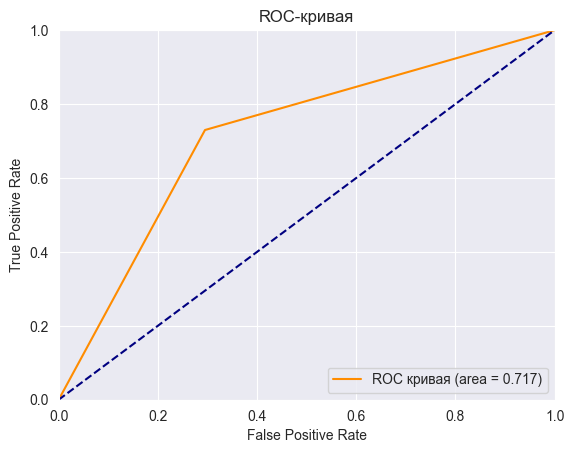

In [54]:
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Как мы можем увидеть, метрика модели улучшилась. Расчтаем оптальный порог класификации с вышеуказанным параметром

In [55]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_test = probabilities_one_test > threshold 
    precision = precision_score(target_test,predicted_test) 
    recall = recall_score(target_test,predicted_test) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, ROC_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_test, predicted_test), roc_auc_score(target_test, predicted_test)))

Порог = 0.00 | Точность = 0.203, Полнота = 1.000, F1 = 0.338, ROC_auc = 0.500
Порог = 0.02 | Точность = 0.203, Полнота = 1.000, F1 = 0.338, ROC_auc = 0.500
Порог = 0.04 | Точность = 0.203, Полнота = 1.000, F1 = 0.338, ROC_auc = 0.500
Порог = 0.06 | Точность = 0.204, Полнота = 0.998, F1 = 0.338, ROC_auc = 0.500
Порог = 0.08 | Точность = 0.204, Полнота = 0.998, F1 = 0.339, ROC_auc = 0.502
Порог = 0.10 | Точность = 0.206, Полнота = 0.998, F1 = 0.342, ROC_auc = 0.508
Порог = 0.12 | Точность = 0.209, Полнота = 0.993, F1 = 0.345, ROC_auc = 0.515
Порог = 0.14 | Точность = 0.212, Полнота = 0.993, F1 = 0.349, ROC_auc = 0.525
Порог = 0.16 | Точность = 0.218, Полнота = 0.993, F1 = 0.357, ROC_auc = 0.541
Порог = 0.18 | Точность = 0.223, Полнота = 0.983, F1 = 0.364, ROC_auc = 0.554
Порог = 0.20 | Точность = 0.229, Полнота = 0.978, F1 = 0.371, ROC_auc = 0.568
Порог = 0.22 | Точность = 0.234, Полнота = 0.966, F1 = 0.377, ROC_auc = 0.579
Порог = 0.24 | Точность = 0.244, Полнота = 0.956, F1 = 0.389, RO

При пороговом значении = 0.52, качество модели возрастает в разы, и уже не является случайной моделью, которую мы видели при работе с несбалансированными классами. Расмотим модель случайного леса с балансом классов и найдем оптимальные гиперпараметры.

In [56]:
%%time
parameters = {
    'n_estimators' : [25,50,100,150],
    'criterion' : ['gini', 'entropy'],
    'max_depth':[5,10,20],
    'class_weight' : ['balanced'],
}

rfc = RandomForestClassifier(random_state=12345)

clf_rfc_random = RandomizedSearchCV(
    estimator = rfc,
    param_distributions = parameters,
    n_iter = 10,
    scoring = 'f1',
    cv=5)

clf_rfc_random.fit(features_train, target_train)

Wall time: 12.9 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
                   param_distributions={'class_weight': ['balanced'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20],
                                        'n_estimators': [25, 50, 100, 150]},
                   scoring='f1')

Обучим модель случайного леса и применим наилучшие гиперпараметры. 

In [57]:
model_rfc_b = clf_rfc_random.best_estimator_.fit(features_train, target_train)
predicted_test = model_rfc_b.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.6295399515738499
ROC_auc: 0.7695044813688882


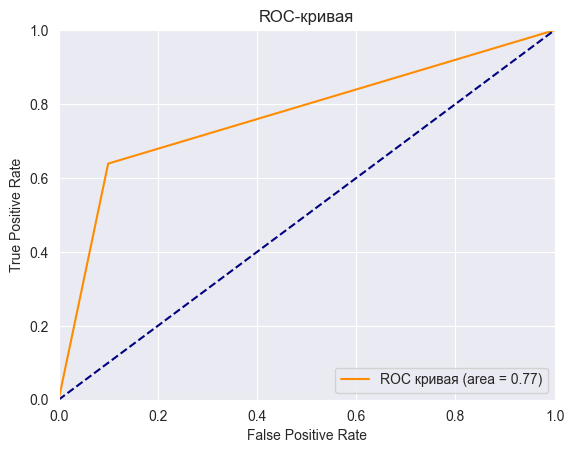

In [58]:
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Как мы можем увидеть, качество модели возрасло, значение метрики увеличлось. Расчитаем оптимальные проговые значения для модели "случайный лес".

probabilities_test = model_rfc_b.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_test = probabilities_one_test > threshold 
    precision = precision_score(target_test,predicted_test) 
    recall = recall_score(target_test,predicted_test) 
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.3f}, ROC_auc = {:.3f}".format(
        threshold, precision, recall, f1_score(target_test, predicted_test), roc_auc_score(target_test, predicted_test)))

При применении гиперпараметра class_weight = 'balanced' для борьбы с дисбалансом классов модель логистической регрессии  показала результат на тестовой выборке по f1 0,51 и  roc_auc 0,71, что значительно лучше, чем без данного гиперпараметра.
Модель случайного леса показала результат на тестовой выборке по f1 0.62 и  roc_auc 0,76. Результат по метрикам случайного леса так же лучше результата без применения гиперпараметра class_weight = 'balanced'.
При изменении порога модель случайного леса показала лучшей результат при пороге равном 0,46 - F1 = 0.628, ROC_auc = 0.786

Применим другой спомо борьбы с дисбалансом, а именно увеличение и уменьшение выборки, для начала увеличим выборку. 

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)    
    return features_upsampled, target_upsampled

In [59]:
sm = SMOTE(random_state=42, k_neighbors=5)

In [60]:
features_upsampled, target_upsampled = sm.fit_resample(features_train, target_train)

target_train = target_train.reset_index(drop=True) 

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Обучим логистическую регресию и расчитаем метрики модели.

In [61]:
model = LogisticRegression(random_state=12345,solver='liblinear')
model.fit(features_upsampled,target_upsampled)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5016891891891891
ROC_auc: 0.7142057311548837


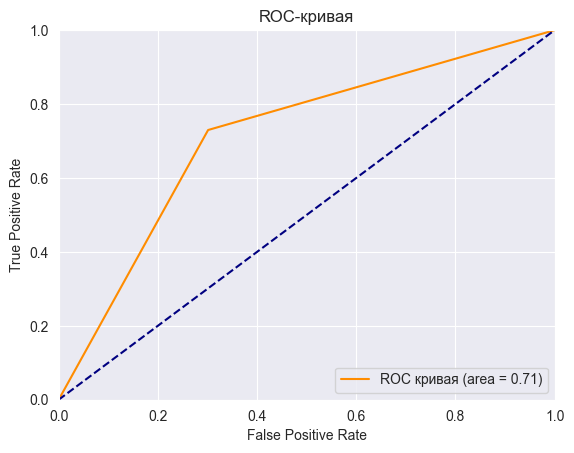

In [62]:
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Модель значительно улучшила свои показатели, по сравнению с несбалансрованными классами. Теперь подберем оптимальные гипер параметры для модели случайного леса на увеличенной, сбалансированной выборке и обучм ее.

In [63]:
%%time
parameters = {
    'n_estimators' : [25,50,100,150],
    'criterion' : ['gini', 'entropy'],
    'max_depth':[5,10,20]
}

rfc = RandomForestClassifier(random_state=12345)

clf_rfc_upsampled_random = RandomizedSearchCV(
    estimator = rfc,
    param_distributions = parameters,
    n_iter = 10,
    scoring = 'f1',
    cv=5)

clf_rfc_upsampled_random.fit(features_upsampled, target_upsampled)

Wall time: 28.4 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20],
                                        'n_estimators': [25, 50, 100, 150]},
                   scoring='f1')

In [64]:
model_rfc_upsampled = clf_rfc_upsampled_random.best_estimator_.fit(features_upsampled, target_upsampled)
predicted_test = model_rfc_upsampled.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5828877005347594
ROC_auc: 0.7292068648000851


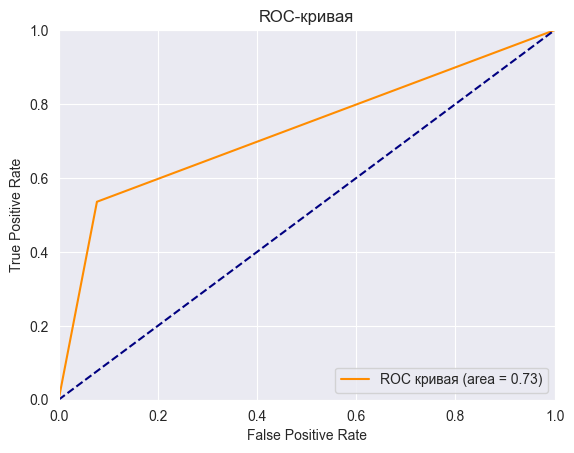

In [65]:
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Модель так же улучшила свои показатели. Проделаем теже шали для градиенткного бустинга. 

In [66]:
%%time
parameters = {
    'learning_rate' : [0.1, 0.01],
    'n_estimators' : [50, 100, 150],
    'max_depth':[3,5,10,20],
}

model_boost = GradientBoostingClassifier(random_state=12345)

clf_gbc_upsampled_random = RandomizedSearchCV(
    estimator = model_boost,
    param_distributions = parameters,
    scoring = 'f1',
    n_iter = 10,
    cv=5)
    
clf_gbc_upsampled_random.fit(features_upsampled, target_upsampled)

Wall time: 2min 18s


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(random_state=12345),
                   param_distributions={'learning_rate': [0.1, 0.01],
                                        'max_depth': [3, 5, 10, 20],
                                        'n_estimators': [50, 100, 150]},
                   scoring='f1')

In [67]:
model_gbc_upsampled = clf_gbc_upsampled_random.best_estimator_.fit(features_upsampled, target_upsampled)
predicted_test = model_gbc_upsampled.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5714285714285715
ROC_auc: 0.7200605844673642


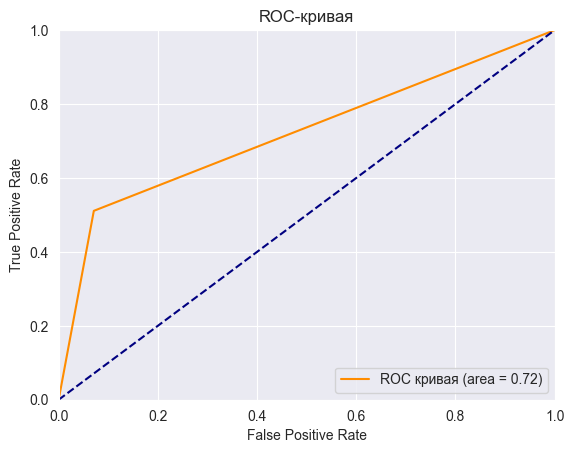

In [68]:
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

При увеличении выбоки для борьбы с дисбалансом классов метрики логистической регресси f1 и roc_auc составили соответственно 0,50 и 0,72 , данный результат практически соответствует результату, полученному при применении гиперпараметра class_weight = 'balanced' для логистической регрессии.  
При увеличении выбоки для борьбы с дисбалансом классов метрики случайного леса на тестовых данных f1 и roc_auc составили соответственно 0,59 и 0,73 , данный результат хуже результата, полученному при применении гиперпараметра class_weight = 'balanced' для случайного леса(0,60 и 0,77 соответственно).  
Градиентный бустинг, обученный на увеличенной выборке, показал на тестовых данных результат по f1 и roc_auc соответственно 0,57 и 0,72, что незначительно лучше результату по градиентному бустингу, обученному на первоначальном датафрейме ( с дисбалансом классов).

Теперь уменьшим выборки для борьбы с дисбалансом. 

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)    
    return features_downsampled, target_downsampled

In [69]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy=1)           
features_downsampled, target_downsampled = under.fit_resample(features_train, target_train)

Обучим логистическую регрессию, на уменьшенной обучающей выборке. 

In [70]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_downsampled,target_downsampled)
predicted_test = model.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5054759898904801
ROC_auc: 0.7178912348403873


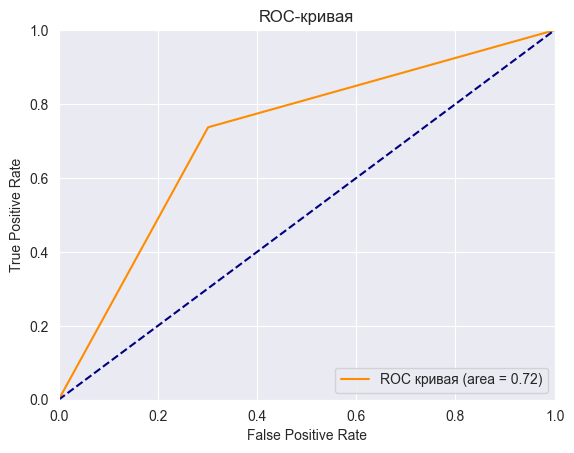

In [71]:
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

На данной выборке, модель показала себя немного хуже, чем на увеличенной выборке. Продолжим изучение других моделей. Найдем оптимальные параметры для случайного леса и проделаем аналогичные шаги. 

In [121]:
%%time
parameters = {
    'n_estimators' : [25,50,100,150, 200],
    'criterion' : ['gini', 'entropy'],
    'max_depth':[5,10,20, 30]
}

rfc = RandomForestClassifier(random_state=12345)

clf_rfc_downsampled_random = RandomizedSearchCV(
    estimator = rfc,
    param_distributions = parameters,
    n_iter = 10,
    scoring = 'f1',
    cv=5)

clf_rfc_downsampled_random.fit(features_downsampled,target_downsampled)

Wall time: 14.4 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 20, 30],
                                        'n_estimators': [25, 50, 100, 150,
                                                         200]},
                   scoring='f1')

In [120]:
model_rfc_downsampled = clf_rfc_downsampled_random.best_estimator_.fit(features_downsampled,target_downsampled)
predicted_test = model_rfc_downsampled.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5920303605313093
ROC_auc: 0.7781448628906257


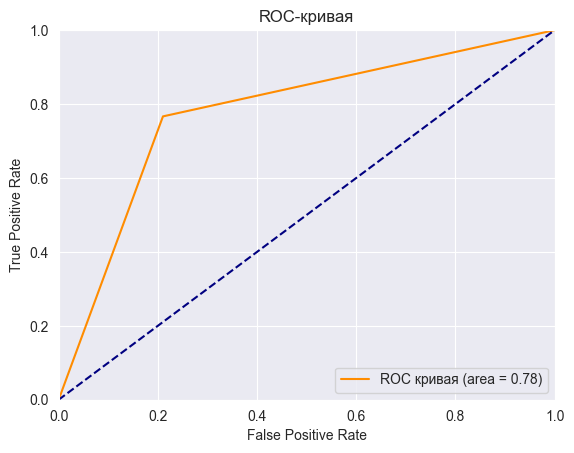

In [118]:
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Метрика модели ухудшилась, по сравнению с увеличенной выборкой. Изучим градиентный буст. 

In [75]:
%%time
parameters = {
    'learning_rate' : [0.1, 0.01],
    'n_estimators' : [50, 100, 150],
    'max_depth':[3,5,10,20],
}

model_boost = GradientBoostingClassifier(random_state=12345)

clf_gbc_downsampled_random = RandomizedSearchCV(
    estimator = model_boost,
    param_distributions = parameters,
    scoring = 'f1',
    n_iter = 10,
    cv=5)
    
clf_gbc_downsampled_random.fit(features_downsampled,target_downsampled)

Wall time: 45.5 s


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(random_state=12345),
                   param_distributions={'learning_rate': [0.1, 0.01],
                                        'max_depth': [3, 5, 10, 20],
                                        'n_estimators': [50, 100, 150]},
                   scoring='f1')

In [76]:
model_gbc_downsampled = clf_gbc_downsampled_random.best_estimator_.fit(features_downsampled,target_downsampled)
predicted_test = model_gbc_downsampled.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.6076923076923076
ROC_auc: 0.7887085853187549


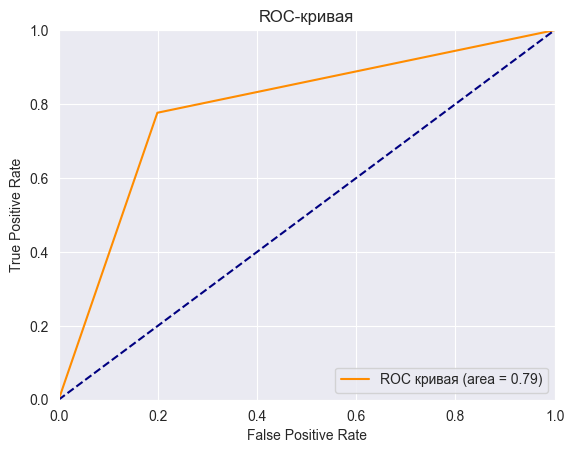

In [77]:
fpr, tpr, treshold = roc_curve(target_test, predicted_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

При уменьшении выбоки для борьбы с дисбалансом классов метрики логистической регресси f1 и roc_auc составили соответственно 0,51 и 0,72 , данный результат практически  соответствует результатам, полученным при применении гиперпараметра class_weight = 'balanced' и  при применении метода увеличения обучающей выборки для логистической регрессии.  
При уменьшении выбоки для борьбы с дисбалансом классов метрики случайного леса на валидных данных f1 и roc_auc составили соответственно 0,59  и 0,77.  
Градиентный бустинг, обученный на уменьшенной выборке, показал на тестовых данных результат по f1 и roc_auc соответственно 0,59 и 0,77. Лучшей моделью является - "Случайный лес". Дальнейшую работу будем проводить на модели "Случайный лес"

## Тестирование модели

В начале теста посмотрим, на сколько наши модели могут выдавать результат, а именно проверим, не являются ли они константными и не выдают ли они один вариант ответа. 

In [78]:
def all_models_share(features_train, target_train, features_valid, target_valid):
    model_GBC = GradientBoostingClassifier(random_state=123)
    model_GBC.fit(features_train, target_train)
    DTC_share = pd.Series(model_GBC.predict(features_valid)).value_counts(normalize = 1)
    
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
    model_RFC.fit(features_train, target_train)
    RFC_share = pd.Series(model_RFC.predict(features_valid)).value_counts(normalize = 1)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    model_LgR.fit(features_train, target_train)
    LgR_share = pd.Series(model_LgR.predict(features_valid)).value_counts(normalize = 1)
    
    print("Доли ответов:" "градиентный бустинг", DTC_share, "случайный лес ", RFC_share, "логистческая регрессия", LgR_share , end='')

In [79]:
all_models_share(features_train, target_train, features_valid, target_valid)

Доли ответов:градиентный бустинг 0   0.884000
1   0.116000
dtype: float64 случайный лес  0   0.877500
1   0.122500
dtype: float64 логистческая регрессия 0   0.936000
1   0.064000
dtype: float64

Все наши модели выдают различный вариант отета. Проведем тесты над моделью "Случайный лес" с различными гипер параметрами и пороговыми значениями, для нахождения лучших гипер параметров. 

In [80]:
clf_rfc_random.best_params_ # выводим на экран лушие гиперпараметры модели.

{'n_estimators': 50,
 'max_depth': 10,
 'criterion': 'gini',
 'class_weight': 'balanced'}

Обучаем модель.

In [81]:
random_forest = RandomForestClassifier(
    n_estimators=150, max_depth=10, random_state=12345, criterion= 'entropy')
random_forest.fit(features_train, target_train)
threshold = 0.28

predicted_proba = random_forest.predict_proba(features_valid)
predicted_random_forest = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(target_valid, predicted_random_forest)

Расчитаем и выведем метрики модели 

In [82]:
print(accuracy)
print("F1:", f1_score(target_valid, predicted_random_forest))
print("ROC_auc:", roc_auc_score(target_valid, predicted_random_forest))

0.841
F1: 0.6353211009174313
ROC_auc: 0.7812866795917643


Построим Roc-кривую

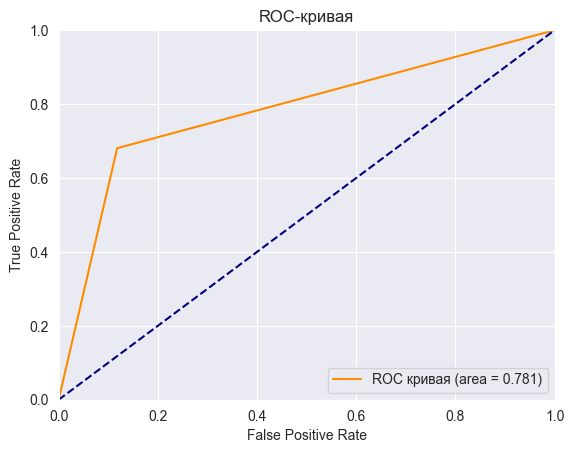

In [83]:
fpr, tpr, treshold = roc_curve(target_valid, predicted_random_forest)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Проделаем вышеуказанные пункты для модели "Случайный лес" и определим наилучшие гипер параметры.

In [84]:
clf_rfc_downsampled_random.best_params_

{'n_estimators': 100, 'max_depth': 10, 'criterion': 'gini'}

In [85]:
random_forest_downsampled = RandomForestClassifier(
    n_estimators=50, max_depth=5, random_state=12345, criterion= 'entropy')
random_forest_downsampled.fit(features_downsampled,target_downsampled)
threshold = 0.28

predicted_proba = random_forest.predict_proba(features_valid)
predicted_random_forest_downsampled = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(target_valid, predicted_random_forest_downsampled)

In [86]:
print(accuracy)
print("F1:", f1_score(target_valid, predicted_random_forest_downsampled))
print("ROC_auc:", roc_auc_score(target_valid, predicted_random_forest_downsampled))

0.841
F1: 0.6353211009174313
ROC_auc: 0.7812866795917643


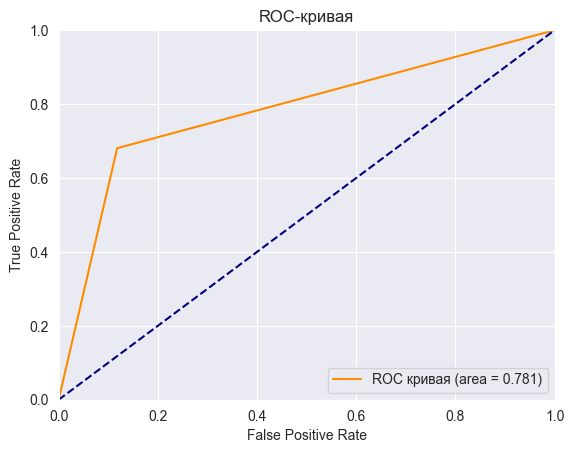

In [87]:
fpr, tpr, treshold = roc_curve(target_valid, predicted_random_forest_downsampled)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

In [88]:
clf_rfc_random.best_params_

{'n_estimators': 50,
 'max_depth': 10,
 'criterion': 'gini',
 'class_weight': 'balanced'}

In [89]:
random_forest = RandomForestClassifier(
    n_estimators=150, max_depth=10, random_state=12345, criterion= 'entropy', class_weight='balanced')
random_forest.fit(features_train, target_train)
threshold = 0.54

predicted_proba = random_forest.predict_proba(features_valid)
predicted_random_forest = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(target_valid, predicted_random_forest)

In [90]:
print(accuracy)
print("F1:", f1_score(target_valid, predicted_random_forest))
print("ROC_auc:", roc_auc_score(target_valid, predicted_random_forest))

0.857
F1: 0.6379746835443039
ROC_auc: 0.7684649210072939


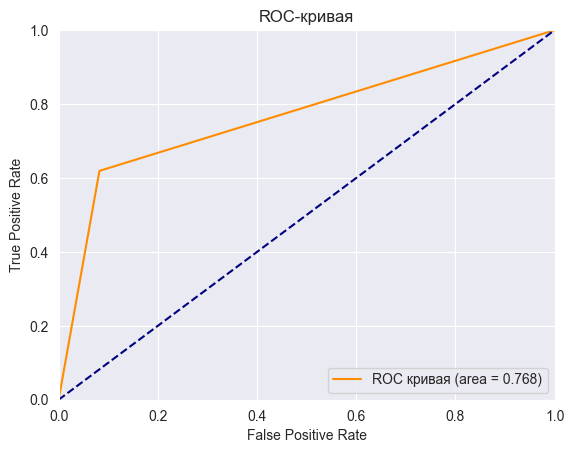

In [91]:
fpr, tpr, treshold = roc_curve(target_valid, predicted_random_forest)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

In [92]:
clf_rfc_upsampled_random.best_params_

{'n_estimators': 100, 'max_depth': 20, 'criterion': 'entropy'}

In [93]:
random_forest_upsampled = RandomForestClassifier(
    n_estimators=150, max_depth=20, random_state=12345, criterion= 'gini')
random_forest_upsampled.fit(features_upsampled, target_upsampled)
predicted_random_forest_upsampled = random_forest_upsampled.predict(features_valid)
accuracy = accuracy_score(target_valid, predicted_random_forest_upsampled)

In [94]:
print(accuracy)
print("F1:", f1_score(target_valid, predicted_random_forest_upsampled))
print("ROC_auc:", roc_auc_score(target_valid, predicted_random_forest_upsampled))

0.8425
F1: 0.592496765847348
ROC_auc: 0.7383261535803909


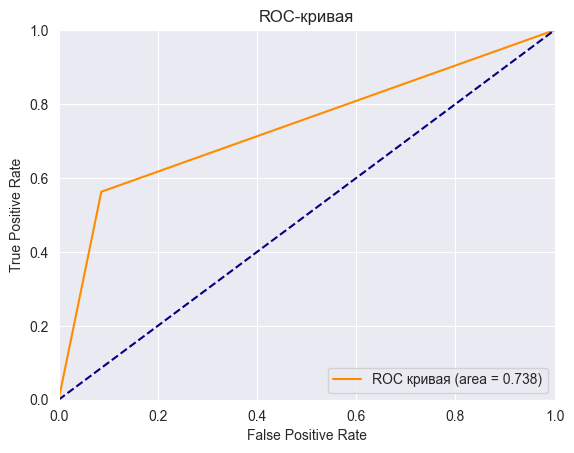

In [95]:
fpr, tpr, treshold = roc_curve(target_valid, predicted_random_forest_upsampled)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Модель случайного леса с гипер параметрами {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50} показала самые лучшие метрики. Посмотрим, какие критерии влияют на нее больше всего.

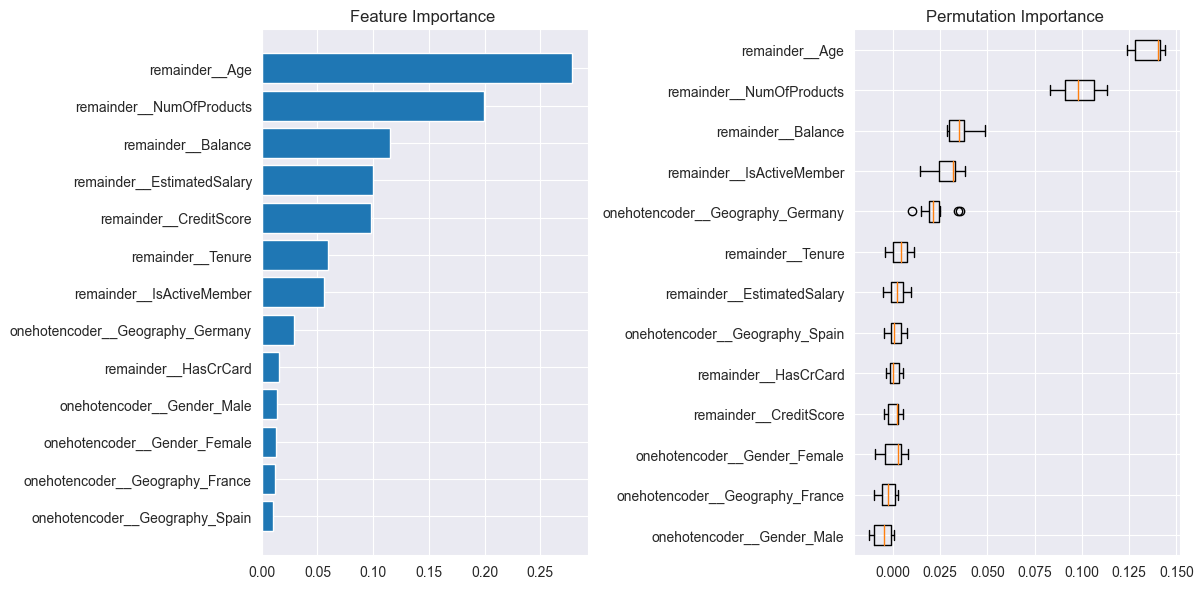

In [96]:
feature_importance = random_forest.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features_valid.columns)[sorted_idx])
plt.title("Feature Importance ")

result = permutation_importance(
    clf_rfc_downsampled_random, features_valid, target_valid, n_repeats=10, random_state=12345
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(features_valid.columns)[sorted_idx],
)
plt.title("Permutation Importance ")
fig.tight_layout()
plt.show()

Лучшая модель это модель- Случайный лес с гипер вараметрами - {'n_estimators': 50, 'max_depth': 10, 'criterion': 'entropy'} и пороговым значение = 0.28. Мы получили аналогичные значения метрик для модели "Случайный лес" с гипер параметрами - {'n_estimators': 150, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': 'balanced'}.
В модели сильно выделяются 2 основных фактора : возраст и количество продуктов. Так же достаточно существенно влияет баланс на счете и активность клиента. При количестве случайного перемешивания объектов равном 10 важность признаков для данного набора данных существенно не изменяется. Так же остается самый существенный фактор это возраст, далее количество продуктов, активность и баланс на счете.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*